# Quellspektren

Short description of example notebook for the Examples Page
Additional information

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Necessary packages for this Example

In [2]:
#pip install - q ...

# Imports

In [29]:
import os
import logging
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#...

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

try:
    from PT3S import ncd
except:
    import ncd
#...

In [4]:
import importlib

In [5]:
#importlib.reload(ncd)

In [6]:
#import inspect
#source_code = inspect.getsource(ncd)
#print(source_code)

# Logging

In [7]:
logger = logging.getLogger()  

logFileName= r"Example7.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [8]:
dbFilename="Example5"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [9]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True)#maxRecords=-1

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example5.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\Example5.db3 is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.XML is newer than
+..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MX1:
+SirCalc's xmlFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


In [57]:
dfEBES=m.dx.dataFrames['EBES']
dfEBES_BZ=m.dx.dataFrames['EBES_BZ']

In [58]:
# Merge dfEBES and dfEBES_BZ on columns 'pk' and 'fk'
vEBES = pd.merge(dfEBES, dfEBES_BZ, left_on='pk', right_on='fk', suffixes=('', '_BZ')).sort_values(by=['LFDNR', 'AKTIVQS']).reset_index()
vEBES

,index,pk,fkDE,rk,tk,NAME,LFDNR,OBJS,DELETED,SELECT1,IDREFERENZ,pk_BZ,fkDE_BZ,fk,AKTIV,AKTIVQS,VERSAGENSW,GRAF
0,1,5408410878987506184,5613149064237404433,5408410878987506184,4947747250455344469,A,1.0,b'FWES~5237816858835684263',0.0,None,-1,5011706316339838135,5032285329913031496,5408410878987506184,101.0,101.0,0.0,None
1,0,5622504138093320653,5613149064237404433,5622504138093320653,5601957102971980247,B,2.0,b'FWES~5175187672733343279',0.0,None,-1,5184693889865717961,5032285329913031496,5622504138093320653,100.0,101.0,0.0,None


In [59]:
# Create lists of NAME and LFDNR from the merged DataFrame
Names = vEBES['NAME'].tolist()
Lfdnrs = vEBES['LFDNR'].tolist()

In [60]:
Names

['A', 'B']

In [61]:
Lfdnrs

[1.0, 2.0]

In [62]:
# Generate a list of column names based on LFDNR and NAME
expColNames = ['qs' + '_' + str(Lfdnr) + '_' + Name for Lfdnr, Name in zip(Lfdnrs, Names)]
expColNames

['qs_1.0_A', 'qs_2.0_B']

In [63]:
# Check for inactive groups with AKTIVQS as float
if not vEBES.shape == vEBES[vEBES['AKTIVQS'] == 101.0].shape:
    print("Es gibt inaktive Einspeisergruppen!")

In [64]:
df=m.V3_KNOT

In [65]:
col_tuple = ('STAT', 'KNOT~*~*~*~ESQUELLSP', pd.Timestamp('2024-01-09 23:00:00'), pd.Timestamp('2024-01-09 23:00:00'))

In [66]:
df['qsStr'] = df[col_tuple].str.decode('utf-8')

In [67]:
df['qsStr'] = df['qsStr'].str.rstrip()

In [68]:
df['srcvector'] = df['qsStr'].apply(lambda x: [x.split('\t')[0].strip()] + [elem.strip() for elem in x.split('\t')[1:]])

In [69]:
gdf_KNOT = m.gdf_KNOT.dropna(subset=['geometry'])

In [70]:
df = pd.merge(gdf_KNOT, df[['pk', 'srcvector']], on='pk', how='left')

In [71]:
df['first_element'] = df['srcvector'].apply(lambda x: x[0] if isinstance(x, list) else None)

In [72]:
df['second_element'] = df['srcvector'].apply(lambda x: x[1] if isinstance(x, list) else None)

In [73]:
df['first_element'] = df['first_element'].astype(float)

In [74]:
df['second_element'] = df['first_element'].astype(float)

In [75]:
df = df.dropna(subset=['dPH'])

In [76]:
# Drop rows where 'YKOR' is less than 90000 or 'XKOR' is less than 40000
df = df[(df['YKOR'] >= 90000) & (df['XKOR'] >= 40000)]

In [77]:
df.head()

,pk,fkDE,rk,tk,NAME,KTYP,XKOR,YKOR,ZKOR,QM_EIN,...,"(STAT, KNOT~*~*~*~QM, 2024-01-09 23:00:00, 2024-01-09 23:00:00)","(STAT, KNOT~*~*~*~RHO, 2024-01-09 23:00:00, 2024-01-09 23:00:00)","(STAT, KNOT~*~*~*~T, 2024-01-09 23:00:00, 2024-01-09 23:00:00)","(STAT, KNOT~*~*~*~VOLD, 2024-01-09 23:00:00, 2024-01-09 23:00:00)",PH,dPH,geometry,srcvector,first_element,second_element
0,4678355169005004036,5613149064237404433,4678355169005004036,4680103632661687203,V-3354,QKON,55176.323661,98780.494875,29.299999,0.0,...,-0.0,1000.299988,10.0,0.0,9.065271,-9.536743e-07,POINT (55176.324 98780.495),"[0, 0]",0.0,0.0
1,5759822415014073091,5613149064237404433,5759822415014073091,5540855804579832866,V-1503,QKON,48826.419913,98285.548412,30.500000,0.0,...,0.0,935.395935,129.782288,0.0,8.247993,2.906271e+00,POINT (48826.420 98285.548),"[100, 0]",100.0,100.0
2,4937617602785191405,5613149064237404433,4937617602785191405,5517245021561014546,R-3120,QKON,54520.835675,98283.398808,28.100000,0.0,...,-0.0,1000.299988,10.0,0.0,9.183028,-1.907349e-06,POINT (54520.836 98283.399),"[0, 0]",0.0,0.0
3,5468959419408453250,5613149064237404433,5468959419408453250,5025567272877293202,V-3604,QKON,53007.627163,98806.657826,26.600000,0.0,...,0.0,936.481689,128.522919,0.0,8.77282,3.201668e+00,POINT (53007.627 98806.658),"[45, 55]",45.0,45.0
4,5526072131156860534,5613149064237404433,5526072131156860534,4660263951317730783,V-IHAF1,QKON,47711.710479,98384.669793,27.600000,0.0,...,0.0,938.922852,125.596466,0.0,7.848343,1.547821e+00,POINT (47711.710 98384.670),"[100, 0]",100.0,100.0


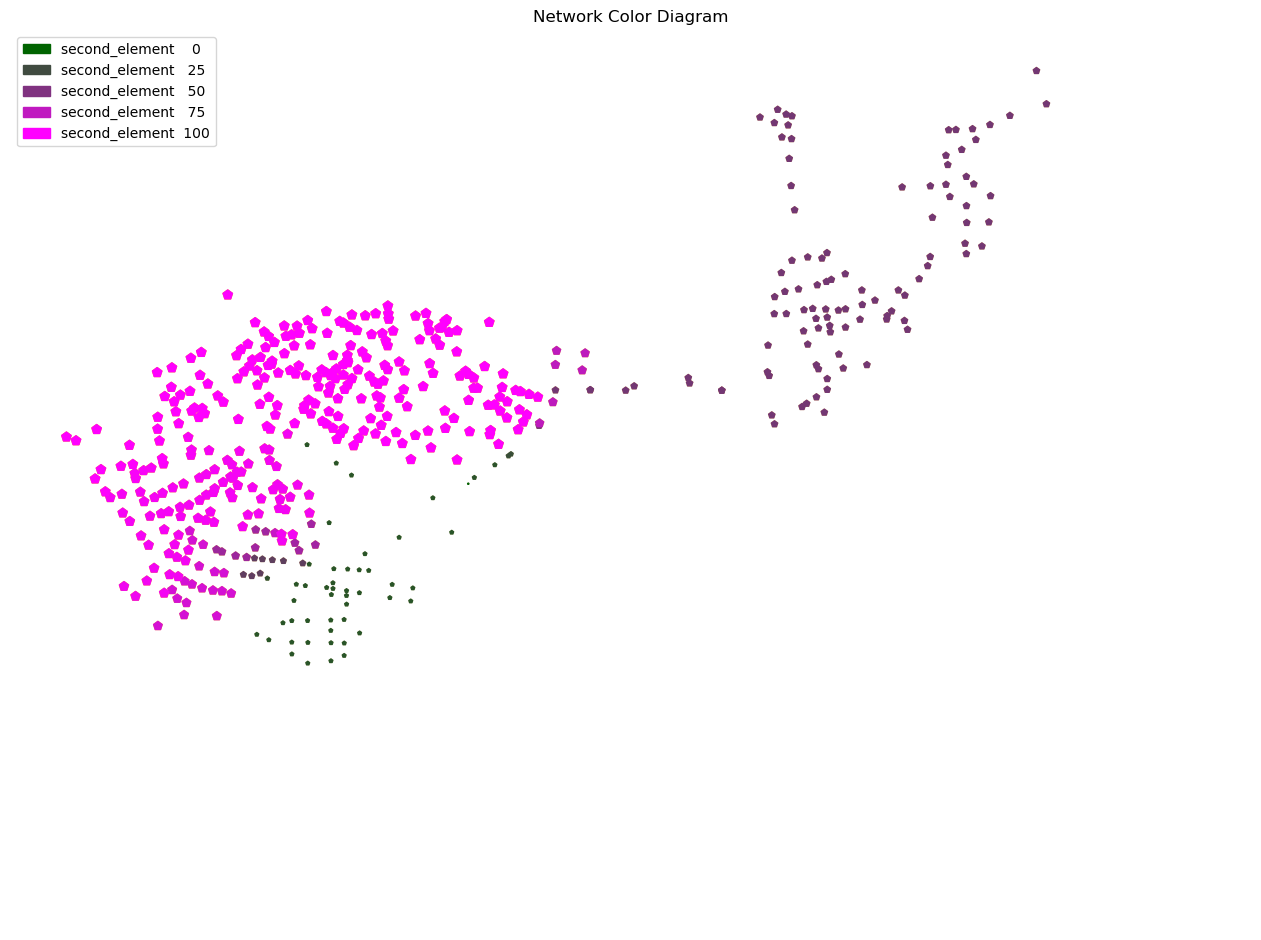

In [78]:
fig, ax = plt.subplots(figsize=Rm.DINA3q)

nodes_patches_1 = ncd.pNcd_nodes(ax=ax,
                                 gdf=df,
                                 attribute='first_element',  # kW
                                 colors=['oldlace', 'orange'],
                                 marker_style='p',
                                 marker_size_factor=50,
                                 #legend_fmt='',
                                 #legend_values=[0, 20, 40, 60, 80],
                                 zorder=1)
nodes_patches_1 = ncd.pNcd_nodes(ax=ax,
                                 gdf=df,
                                 attribute='second_element',  # kW
                                 colors=['darkgreen', 'magenta'],
                                 marker_style='p',
                                 marker_size_factor=50,
                                 #legend_fmt='',
                                 #legend_values=[0, 20, 40, 60, 80],
                                 zorder=1)

all_patches = nodes_patches_1
ax.legend(handles=all_patches, loc='best')

#cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source=cx.providers.CartoDB.PositronNoLabels)
#cx.add_basemap(ax, crs=gdf_ROHR.crs.to_string(), source=cx.providers.CartoDB.PositronOnlyLabels)

plt.title('Network Color Diagram')

plt.savefig('Example7_Output_1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
try:
    from PT3S import Rm
except:
    import Rm
try:
    from PT3S import ncd
except:
    import ncd
import matplotlib.pyplot as plt
import contextily as cx

